In [20]:
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [21]:
sc = MinMaxScaler(feature_range=(0,1))
df_train = pd.read_csv('../data/market_data.csv', parse_dates=['Time'], index_col='Time')
train_set = df_train[:'2026'].iloc[:,1:2].values 
sc.fit(train_set)


,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(0, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data toprovided `feature_range`.Since this parameter will clip values, `inverse_transform` may notbe able to restore the original data... note:: Setting `clip=True` does not prevent feature drift (a distribution shift between training and test data). The transformed values are clipped to the `feature_range`, which helps avoid unintended behavior in models sensitive to out-of-range inputs (e.g. linear models). Use with care, as clipping can distort the distribution of test data... versionadded:: 0.24",False


Predicted prices for the next day:
[[91382.664]
 [91382.664]
 [91382.63 ]
 [91382.59 ]
 [91382.54 ]
 [91382.48 ]
 [91382.4  ]
 [91382.305]
 [91382.22 ]
 [91382.125]]


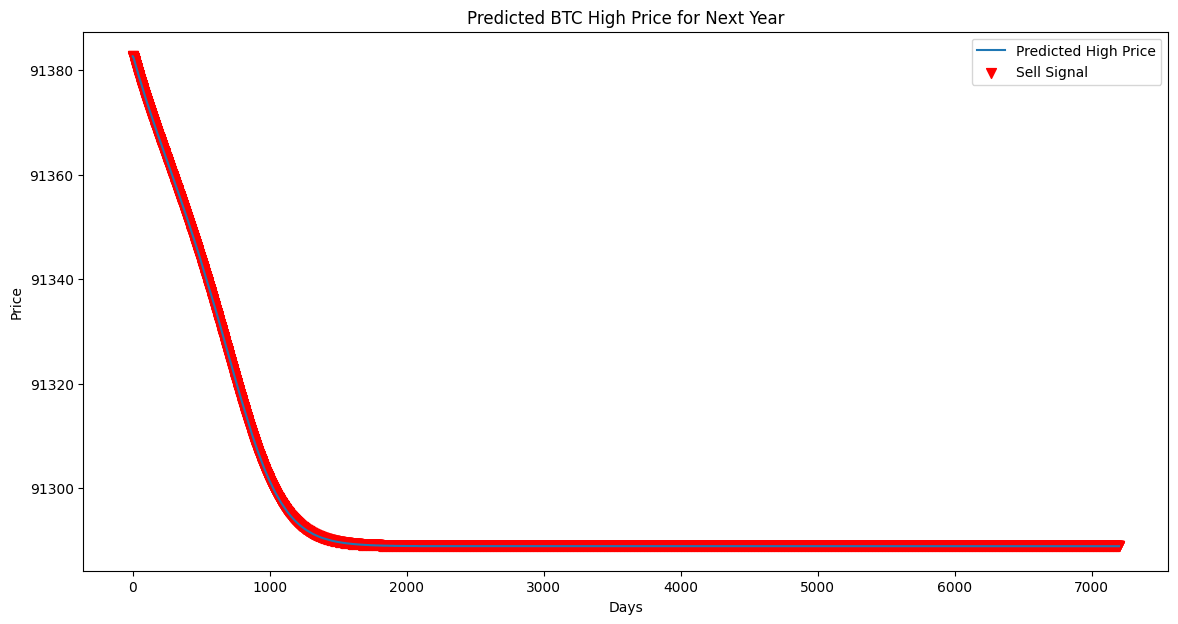

In [23]:
model = load_model('../model.h5')
df_new = pd.read_csv('../data/market_data.csv')
if 'Time' in df_new.columns:
    df_new = df_new.set_index('Time')
new_data = df_new['High'].values.reshape(-1,1)
new_data_scaled = sc.transform(new_data)
seq_length = 100
if len(new_data_scaled) >= seq_length:
    # Get last 100 points for future prediction
    last_100_scaled = new_data_scaled[-seq_length:]
    
    # Predict next 2h(7200s) points in seconds
    predictions = []
    for _ in range(7200): #TO DO : re-replace it for the DAY 86400 marker #RN 2h prediction
        x_input = last_100_scaled.reshape(1, seq_length, 1)
        pred = model.predict(x_input, verbose=0)
        predictions.append(pred[0][0])
        # Update window
        last_100_scaled = np.append(last_100_scaled[1:], pred[0])
    
    predictions = np.array(predictions).reshape(-1,1)
    pred_prices = sc.inverse_transform(predictions)
    
    print('Predicted prices for the next day:')
    print(pred_prices[:10])  # Show first 10
    
    # Plot
    plt.figure(figsize=(14,7))
    plt.plot(pred_prices, label='Predicted High Price')
    plt.title('Predicted BTC High Price for Next 2H time frame')
    plt.xlabel('Days')
    plt.ylabel('Price')
    
    # Add buy/sell markers
    buy_points = []
    sell_points = []
    prev_price = new_data[-1][0]  # Last actual price
    for i, price in enumerate(pred_prices.flatten()):
        if price > prev_price:
            buy_points.append((i, price))
        else:
            sell_points.append((i, price))
        prev_price = price
    
    if buy_points:
        plt.scatter(*zip(*buy_points), color='green', marker='^', label='Buy Signal', s=50)
    if sell_points:
        plt.scatter(*zip(*sell_points), color='red', marker='v', label='Sell Signal', s=50)
    
    plt.legend()
    plt.show()
    
else:
    print(f'Not enough data for prediction, have {len(new_data_scaled)}, need at least {seq_length} points')